In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [17]:
splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
temp_set = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["train"], lines=True)
test_set = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["test"], lines=True)

train_set, val_set = train_test_split(
    temp_set,
    test_size=0.1,
    random_state=42,
    stratify=temp_set["label"],
)
#train_set, val_set = train_test_split(temp_set, test_size=0.1) changed for reproducity

In [18]:
def separate_labels_text(set: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    x = set.drop(columns=["label"])
    y = set["label"]

    return x,y 

ag_train, y_train = separate_labels_text(train_set)
ag_val, y_val = separate_labels_text(val_set)
ag_test, y_test = separate_labels_text(test_set)

In [19]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(ag_train["title"]+" "+ag_train["description"])
X_val = tfidf.transform(ag_val["title"]+" "+ag_val["description"])
X_test = tfidf.transform(ag_test["title"]+" "+ag_test["description"])




In [20]:
def grid_search(param_grid, x_train, y_train, x_val, y_val, max_iter=100):
    best_model = None
    best_macrof1 = -1.0
    best_params = None

    for c in param_grid["C"]:
        for ratio in param_grid["l1_ratio"]:
            model = LogisticRegression(
                C=c,
                solver="saga",
                l1_ratio=ratio,
                max_iter=max_iter,
                random_state=42,
            )
            model.fit(x_train, y_train)

            pred = model.predict(x_val)

            score = f1_score(y_val, pred, average="macro", zero_division=0)

            if score > best_macrof1:
                best_macrof1 = score
                best_model = model
                best_params = {"C": c, "l1_ratio": ratio}

    return best_model, best_macrof1, best_params


In [21]:
param_grid = {
    "C": [0.1, 1],
    "l1_ratio": [0, 1],
}

best_model, best_macrof1, best_params = grid_search(param_grid, X_train, y_train, X_val, y_val)

print(best_model)
print(best_macrof1)
print(best_params)

LogisticRegression(C=1, l1_ratio=0, random_state=42, solver='saga')
0.9115420590433607
{'C': 1, 'l1_ratio': 0}


/home/ainas/nlp/nlp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
"""
Drop newton-cg because it almost never beats lbfgs in accuracy and it is slower in practice for large datasets
Only keep 1 and 0 as l1 values 
"lbfgs" it is also l2 and performs worse with large sparse datasets 
tol = how small the improvement must be before training stops
"""

'\nDrop newton-cg because it almost never beats lbfgs in accuracy and it is slower in practice for large datasets\nOnly keep 1 and 0 as l1 values \n"lbfgs" it is also l2 and performs worse with large sparse datasets \ntol = how small the improvement must be before training stops\n'

              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.98      0.96      1900
           3       0.87      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



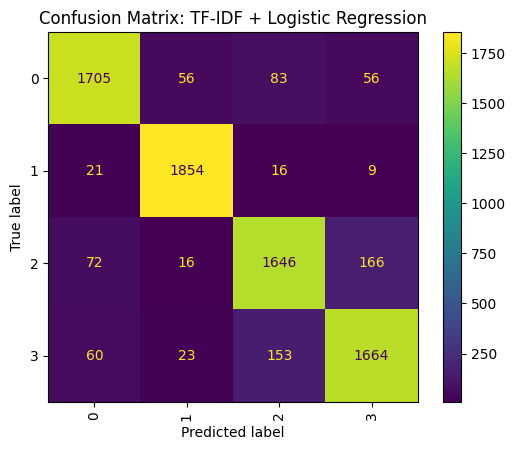

In [23]:
y_pred_test = best_model.predict(X_test)

print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix: TF-IDF + Logistic Regression")
plt.show()

In [24]:
def grid_search_svm(param_grid, x_train, y_train, x_val, y_val, max_iter=100):
    best_model = None
    best_macrof1 = -1.0
    best_params = None

    Cs = param_grid["C"]
    losses = param_grid["loss"]


    # Grid search loop (same format as your LR version)
    for c in Cs:
        for loss in losses:
            model = LinearSVC(
                C=c,
                loss=loss,
                max_iter=max_iter,
                random_state=42,
            )

            model.fit(x_train, y_train)
            pred = model.predict(x_val)
            score = f1_score(y_val, pred, average="macro", zero_division=0)

            if score > best_macrof1:
                best_macrof1 = score
                best_model = model
                best_params = {
                    "C": c,
                    "loss": loss,
                }

    return best_model, best_macrof1, best_params


In [25]:
param_grid_svm = {
    "C": [0.1, 1],
    "loss": ["hinge", "squared_hinge"]
}

best_model_svm, best_macrof1_svm, best_params_svm = grid_search_svm(
    param_grid_svm, X_train, y_train, X_val, y_val
)

print(best_model_svm)
print(best_macrof1_svm)
print(best_params_svm)

/home/ainas/nlp/nlp/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ainas/nlp/nlp/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, loss='hinge', max_iter=100, random_state=42)
0.9141647757068503
{'C': 1, 'loss': 'hinge'}


              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1900
           2       0.95      0.98      0.97      1900
           3       0.87      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



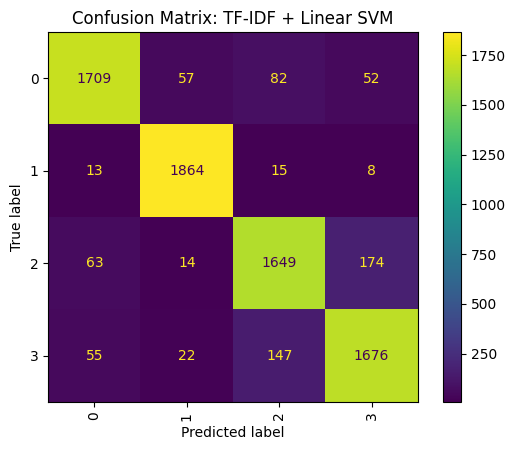

In [26]:
y_pred_test_svm = best_model_svm.predict(X_test)

print(classification_report(y_test, y_pred_test_svm))

cm = confusion_matrix(y_test, y_pred_test_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix: TF-IDF + Linear SVM")
plt.show()

In [27]:
pd.set_option("display.max_colwidth", None)

# AG News label mapping
label_names = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

# --- Logistic Regression Error Analysis ---
df_predictions_lr = pd.DataFrame({
    "title": ag_test["title"],
    "description": ag_test["description"],
    "true_label": y_test.map(label_names),
    "pred_label": pd.Series(y_pred_test).map(label_names).values
})

errors_lr = df_predictions_lr[
    df_predictions_lr["true_label"] != df_predictions_lr["pred_label"]
]

print("=== Logistic Regression ===")
print(f"Total Errors: {len(errors_lr)}")
display(errors_lr.head(20))


errors_lr = df_predictions_lr[df_predictions_lr['true_label'] != df_predictions_lr['pred_label']]

print("=== Logistic Regression ===")
print(f"Total Errors: {len(errors_lr)}")
print("Displaying first 20 misclassifications:")
display(errors_lr.head(20))

# --- LinearSVC Error Analysis ---
df_predictions_svm = pd.DataFrame({
    "title": ag_test["title"],
    "description": ag_test["description"],
    "true_label": y_test.map(label_names),
    "pred_label": pd.Series(y_pred_test_svm).map(label_names).values
})

errors_svm = df_predictions_svm[df_predictions_svm['true_label'] != df_predictions_svm['pred_label']]

print("\n=== LinearSVC ===")
print(f"Total Errors: {len(errors_svm)}")
print("Displaying first 20 misclassifications:")
display(errors_svm.head(20))

=== Logistic Regression ===
Total Errors: 731


,title,description,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",Sci/Tech,Sports
20,IBM to hire even more new workers,"By the end of the year, the computing giant plans to have its biggest headcount since 1991.",Sci/Tech,Business
23,Some People Not Eligible to Get in on Google IPO,"Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.",Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab,"By MICHAEL LIEDTKE SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...",Sci/Tech,Business
36,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.,World,Business
79,Live: Olympics day four,Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.,World,Sports
83,Intel to delay product aimed for high-definition TVs,"SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays.",Business,Sci/Tech
88,U.S. Misses Cut in Olympic 100 Free,"ATHENS, Greece - Top American sprinters Jason Lezak and Ian Crocker missed the cut in the Olympic 100-meter freestyle preliminaries Tuesday, a stunning blow for a country that had always done well in the event. Pieter van den Hoogenband of the Netherlands and Australian Ian Thorpe advanced to the evening semifinal a day after dueling teenager Michael Phelps in the 200 freestyle, won by Thorpe...",World,Sports
106,Stocks Climb on Drop in Consumer Prices,"NEW YORK - Stocks rose for a second straight session Tuesday as a drop in consumer prices allowed investors to put aside worries about inflation, at least for the short term. With gasoline prices falling to eight-month lows, the Consumer Price Index registered a small drop in July, giving consumers a respite from soaring energy prices...",World,Business
110,Yahoo! Ups Ante for Small Businesses,Web giant Yahoo! is gambling that price cuts on its domain name registration and Web hosting products will make it more competitive with discounters in the space -- which means that small businesses looking to move online get a sweeter deal through ...,Business,Sci/Tech


=== Logistic Regression ===
Total Errors: 731
Displaying first 20 misclassifications:


,title,description,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",Sci/Tech,Sports
20,IBM to hire even more new workers,"By the end of the year, the computing giant plans to have its biggest headcount since 1991.",Sci/Tech,Business
23,Some People Not Eligible to Get in on Google IPO,"Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.",Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab,"By MICHAEL LIEDTKE SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...",Sci/Tech,Business
36,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.,World,Business
79,Live: Olympics day four,Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.,World,Sports
83,Intel to delay product aimed for high-definition TVs,"SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays.",Business,Sci/Tech
88,U.S. Misses Cut in Olympic 100 Free,"ATHENS, Greece - Top American sprinters Jason Lezak and Ian Crocker missed the cut in the Olympic 100-meter freestyle preliminaries Tuesday, a stunning blow for a country that had always done well in the event. Pieter van den Hoogenband of the Netherlands and Australian Ian Thorpe advanced to the evening semifinal a day after dueling teenager Michael Phelps in the 200 freestyle, won by Thorpe...",World,Sports
106,Stocks Climb on Drop in Consumer Prices,"NEW YORK - Stocks rose for a second straight session Tuesday as a drop in consumer prices allowed investors to put aside worries about inflation, at least for the short term. With gasoline prices falling to eight-month lows, the Consumer Price Index registered a small drop in July, giving consumers a respite from soaring energy prices...",World,Business
110,Yahoo! Ups Ante for Small Businesses,Web giant Yahoo! is gambling that price cuts on its domain name registration and Web hosting products will make it more competitive with discounters in the space -- which means that small businesses looking to move online get a sweeter deal through ...,Business,Sci/Tech



=== LinearSVC ===
Total Errors: 702
Displaying first 20 misclassifications:


,title,description,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",Sci/Tech,Sports
15,Teenage T. rex's monster growth,Tyrannosaurus rex achieved its massive size due to an enormous growth spurt during its adolescent years.,Sci/Tech,Business
20,IBM to hire even more new workers,"By the end of the year, the computing giant plans to have its biggest headcount since 1991.",Sci/Tech,Business
23,Some People Not Eligible to Get in on Google IPO,"Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.",Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab,"By MICHAEL LIEDTKE SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...",Sci/Tech,Business
36,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.,World,Business
79,Live: Olympics day four,Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.,World,Sports
83,Intel to delay product aimed for high-definition TVs,"SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays.",Business,Sci/Tech
88,U.S. Misses Cut in Olympic 100 Free,"ATHENS, Greece - Top American sprinters Jason Lezak and Ian Crocker missed the cut in the Olympic 100-meter freestyle preliminaries Tuesday, a stunning blow for a country that had always done well in the event. Pieter van den Hoogenband of the Netherlands and Australian Ian Thorpe advanced to the evening semifinal a day after dueling teenager Michael Phelps in the 200 freestyle, won by Thorpe...",World,Sports
106,Stocks Climb on Drop in Consumer Prices,"NEW YORK - Stocks rose for a second straight session Tuesday as a drop in consumer prices allowed investors to put aside worries about inflation, at least for the short term. With gasoline prices falling to eight-month lows, the Consumer Price Index registered a small drop in July, giving consumers a respite from soaring energy prices...",World,Business
